## Stock Market Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('all_stocks_5yr.csv')
df['date'] = pd.to_datetime(df['date'])
top_stocks = df.groupby('Name')['volume'].sum().nlargest(10).index.tolist()
df = df[df['Name'].isin(top_stocks)]
df = df.sort_values(['Name', 'date'])
df['daily_return'] = df.groupby('Name')['close'].pct_change()

def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(data, fast=12, slow=26, signal=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

for stock in top_stocks:
    stock_data = df[df['Name'] == stock]
    df.loc[df['Name'] == stock, 'MA_10'] = stock_data['close'].rolling(window=10).mean()
    df.loc[df['Name'] == stock, 'MA_50'] = stock_data['close'].rolling(window=50).mean()
    df.loc[df['Name'] == stock, 'RSI'] = calculate_rsi(stock_data['close'])
    macd, signal = calculate_macd(stock_data['close'])
    df.loc[df['Name'] == stock, 'MACD'] = macd
    df.loc[df['Name'] == stock, 'MACD_Signal'] = signal
    rolling_mean = stock_data['close'].rolling(window=20).mean()
    rolling_std = stock_data['close'].rolling(window=20).std()
    df.loc[df['Name'] == stock, 'Upper_Band'] = rolling_mean + (rolling_std * 2)
    df.loc[df['Name'] == stock, 'Lower_Band'] = rolling_mean - (rolling_std * 2)

df = df.dropna()

## Exploratory Data Analysis

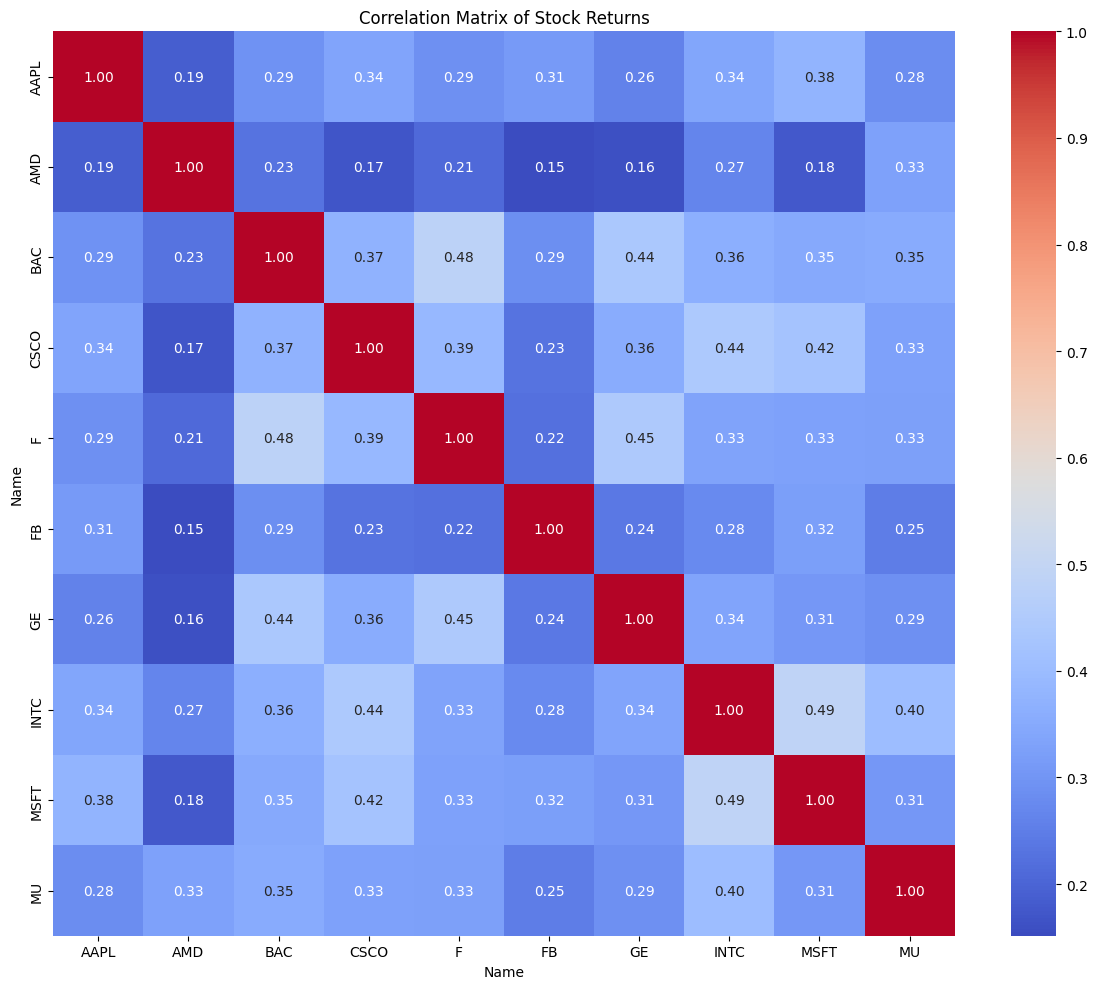

CORRELATION ANALYSIS RESULTS:
Most correlated pair: INTC & MSFT (0.489)
Least correlated pair: AMD & FB (0.152)


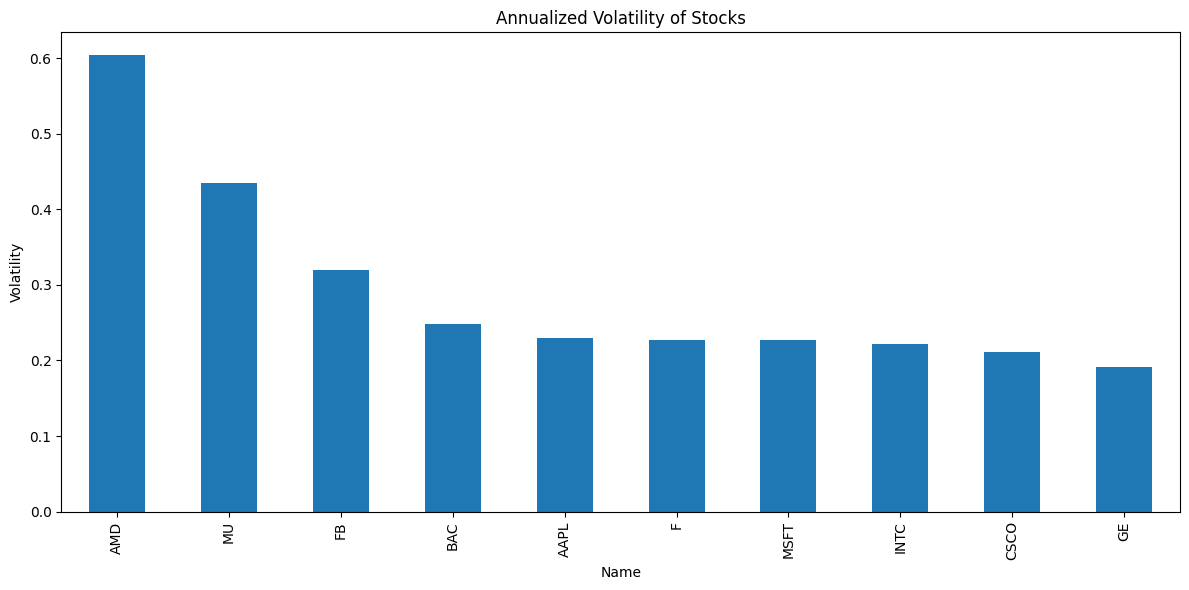

VOLATILITY ANALYSIS RESULTS:
Most volatile stock: AMD (0.604)
Least volatile stock: GE (0.191)


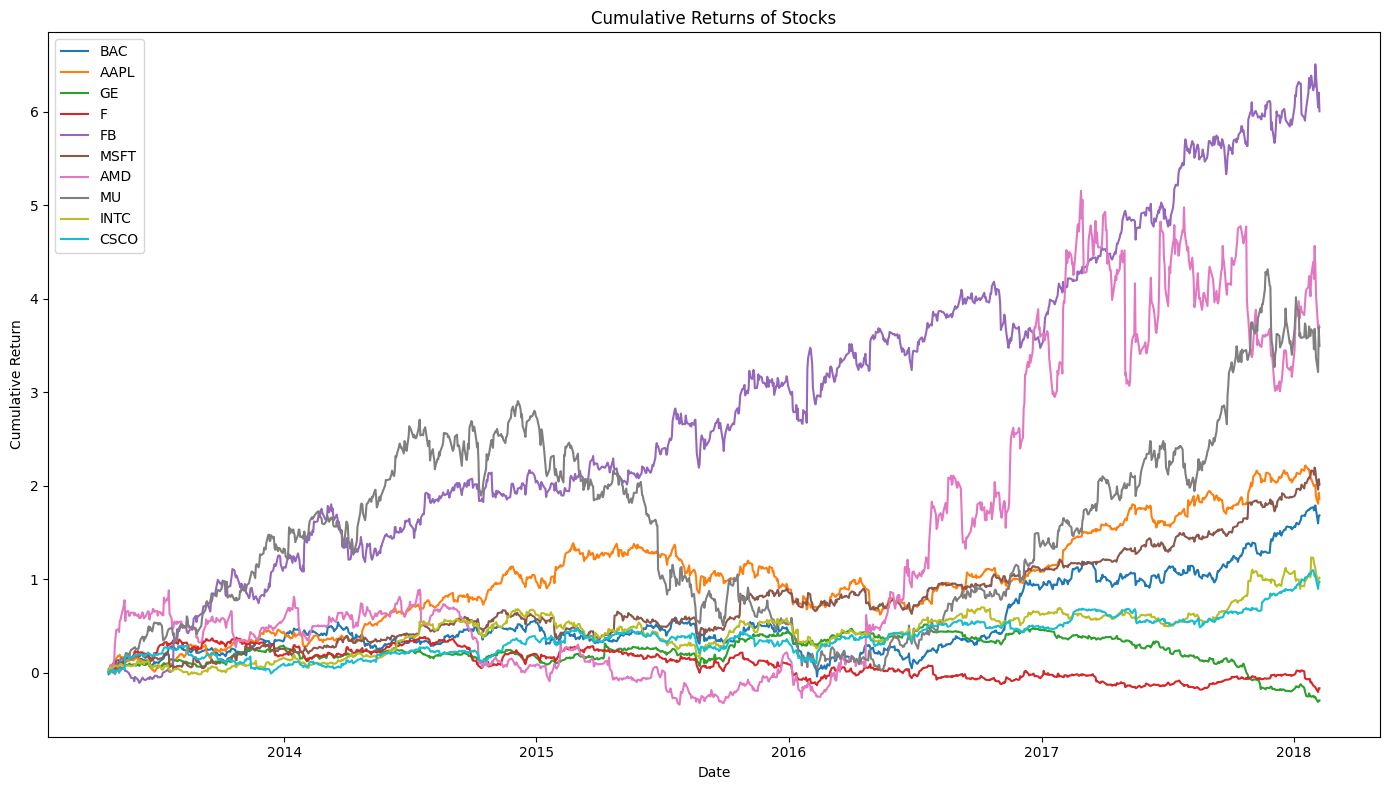

PERFORMANCE ANALYSIS RESULTS:
Best performing stock: FB (600.27%)
Worst performing stock: GE (-29.89%)


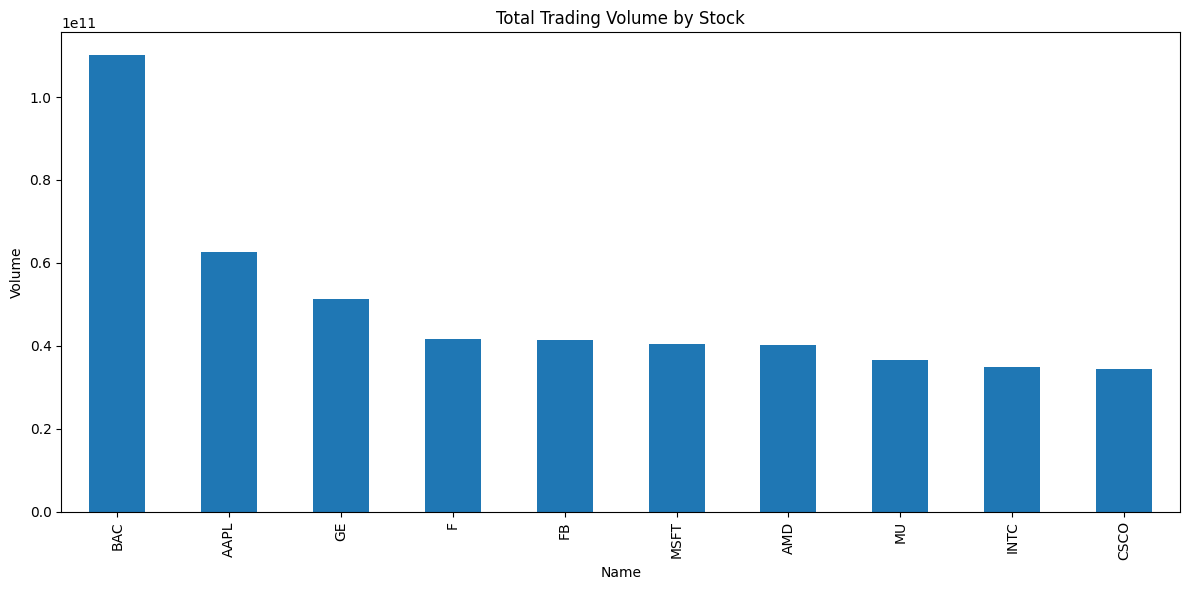

VOLUME ANALYSIS RESULTS:
Most traded stock: BAC (110,101,336,519)
Least traded stock: CSCO (34,326,120,033)


In [3]:
returns_pivot = df.pivot(index='date', columns='Name', values='daily_return')
correlation_matrix = returns_pivot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Stock Returns')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("CORRELATION ANALYSIS RESULTS:")
print(f"Most correlated pair: {corr_pairs[0][0]} & {corr_pairs[0][1]} ({corr_pairs[0][2]:.3f})")
print(f"Least correlated pair: {corr_pairs[-1][0]} & {corr_pairs[-1][1]} ({corr_pairs[-1][2]:.3f})")

volatility = returns_pivot.std() * np.sqrt(252)

plt.figure(figsize=(12, 6))
volatility.sort_values(ascending=False).plot(kind='bar')
plt.title('Annualized Volatility of Stocks')
plt.ylabel('Volatility')
plt.tight_layout()
plt.savefig('volatility.png')
plt.show()

print("VOLATILITY ANALYSIS RESULTS:")
print(f"Most volatile stock: {volatility.idxmax()} ({volatility.max():.3f})")
print(f"Least volatile stock: {volatility.idxmin()} ({volatility.min():.3f})")

cumulative_returns = (1 + returns_pivot).cumprod() - 1

plt.figure(figsize=(14, 8))
for stock in top_stocks:
    plt.plot(cumulative_returns.index, cumulative_returns[stock], label=stock)
plt.title('Cumulative Returns of Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.tight_layout()
plt.savefig('cumulative_returns.png')
plt.show()

final_returns = cumulative_returns.iloc[-1].sort_values(ascending=False)
print("PERFORMANCE ANALYSIS RESULTS:")
print(f"Best performing stock: {final_returns.idxmax()} ({final_returns.max()*100:.2f}%)")
print(f"Worst performing stock: {final_returns.idxmin()} ({final_returns.min()*100:.2f}%)")

total_volume = df.groupby('Name')['volume'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
total_volume.plot(kind='bar')
plt.title('Total Trading Volume by Stock')
plt.ylabel('Volume')
plt.tight_layout()
plt.savefig('trading_volume.png')
plt.show()

print("VOLUME ANALYSIS RESULTS:")
print(f"Most traded stock: {total_volume.idxmax()} ({total_volume.max():,})")
print(f"Least traded stock: {total_volume.idxmin()} ({total_volume.min():,})")

## Portfolio Optimization

PORTFOLIO OPTIMIZATION RESULTS:
Maximum Sharpe Ratio Portfolio:
  Return: 0.3341
  Volatility: 0.2030
  Sharpe Ratio: 1.5475
  Weights: {'BAC': np.float64(0.11016447500960763), 'AAPL': np.float64(0.06757464801064735), 'GE': np.float64(0.15462211564543202), 'F': np.float64(0.012135576873988646), 'FB': np.float64(0.01609270262941344), 'MSFT': np.float64(0.3165387578615612), 'AMD': np.float64(0.025173837525758924), 'MU': np.float64(0.07604543742982461), 'INTC': np.float64(0.07054597188387786), 'CSCO': np.float64(0.15110647712988828)}

Minimum Volatility Portfolio:
  Return: 0.1615
  Volatility: 0.1493
  Sharpe Ratio: 0.9479
  Weights: {'BAC': np.float64(0.16600905678650368), 'AAPL': np.float64(0.014400070428507113), 'GE': np.float64(0.09195453811706683), 'F': np.float64(0.11518434734610596), 'FB': np.float64(0.09632780832535415), 'MSFT': np.float64(0.05184279280827969), 'AMD': np.float64(0.19442178757036405), 'MU': np.float64(0.0985794126793267), 'INTC': np.float64(0.16500839130700598), '

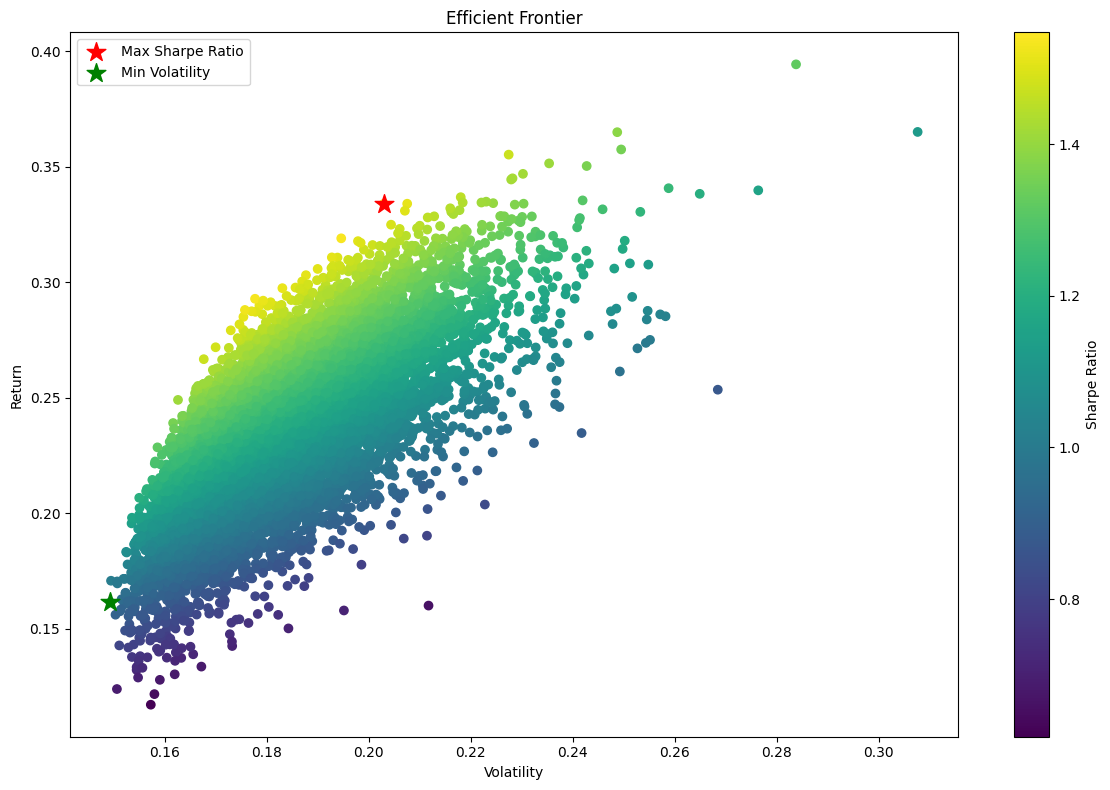

In [4]:
expected_returns = returns_pivot.mean() * 252
cov_matrix = returns_pivot.cov() * 252

def portfolio_performance(weights, expected_returns, cov_matrix):
    returns = np.sum(weights * expected_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, volatility

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.02):
    p_returns, p_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_volatility

num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weight_records = []

for i in range(num_portfolios):
    weights = np.random.random(len(top_stocks))
    weights /= np.sum(weights)
    weight_records.append(weights)
    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = (portfolio_return - 0.02) / portfolio_volatility

results_frame = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio'])
results_frame['Weights'] = weight_records

max_sharpe_idx = results_frame['Sharpe Ratio'].idxmax()
min_volatility_idx = results_frame['Volatility'].idxmin()

optimal_sharpe = results_frame.iloc[max_sharpe_idx]
optimal_volatility = results_frame.iloc[min_volatility_idx]

print("PORTFOLIO OPTIMIZATION RESULTS:")
print(f"Maximum Sharpe Ratio Portfolio:")
print(f"  Return: {optimal_sharpe['Return']:.4f}")
print(f"  Volatility: {optimal_sharpe['Volatility']:.4f}")
print(f"  Sharpe Ratio: {optimal_sharpe['Sharpe Ratio']:.4f}")
print(f"  Weights: {dict(zip(top_stocks, optimal_sharpe['Weights']))}")

print(f"\nMinimum Volatility Portfolio:")
print(f"  Return: {optimal_volatility['Return']:.4f}")
print(f"  Volatility: {optimal_volatility['Volatility']:.4f}")
print(f"  Sharpe Ratio: {optimal_volatility['Sharpe Ratio']:.4f}")
print(f"  Weights: {dict(zip(top_stocks, optimal_volatility['Weights']))}")

plt.figure(figsize=(12, 8))
plt.scatter(results_frame['Volatility'], results_frame['Return'], c=results_frame['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(optimal_sharpe['Volatility'], optimal_sharpe['Return'], marker='*', s=200, c='r', label='Max Sharpe Ratio')
plt.scatter(optimal_volatility['Volatility'], optimal_volatility['Return'], marker='*', s=200, c='g', label='Min Volatility')
plt.title('Efficient Frontier')
plt.legend()
plt.tight_layout()
plt.savefig('efficient_frontier.png')
plt.show()

## Stock Price Prediction

<Figure size 1200x600 with 0 Axes>

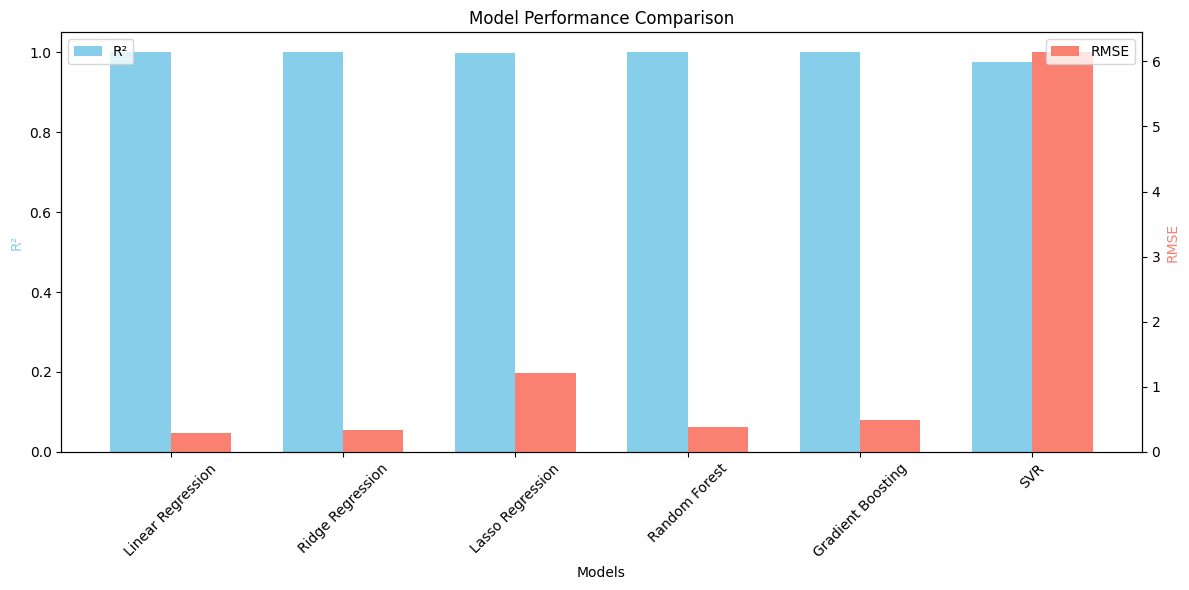

MODEL PERFORMANCE RESULTS:
Linear Regression: R²=1.000, RMSE=0.28, MAE=0.16
Ridge Regression: R²=1.000, RMSE=0.33, MAE=0.18
Lasso Regression: R²=0.999, RMSE=1.21, MAE=0.82
Random Forest: R²=1.000, RMSE=0.38, MAE=0.18
Gradient Boosting: R²=1.000, RMSE=0.50, MAE=0.31
SVR: R²=0.975, RMSE=6.14, MAE=1.71

BEST MODEL: Linear Regression with R²=1.000


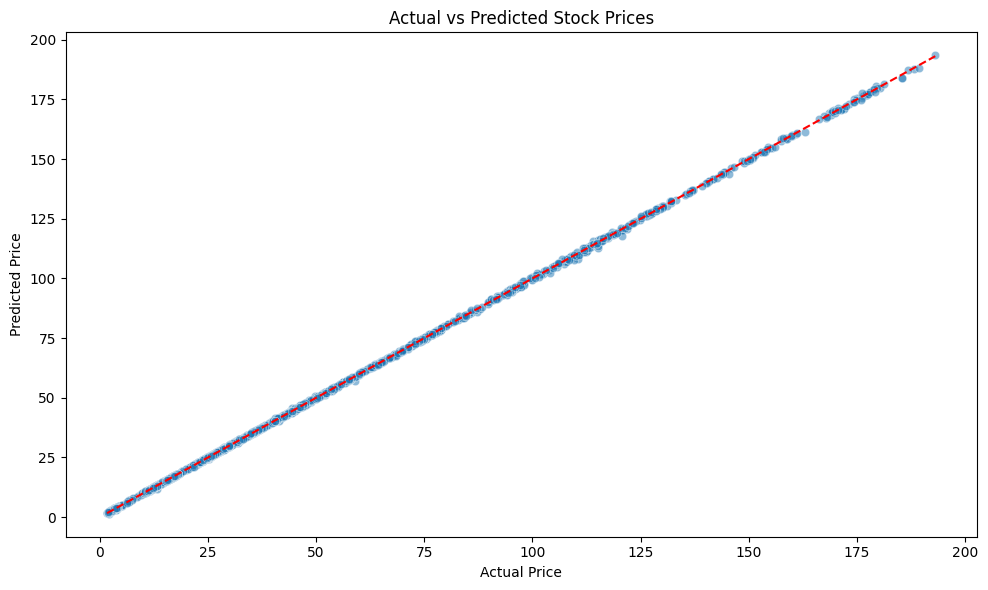

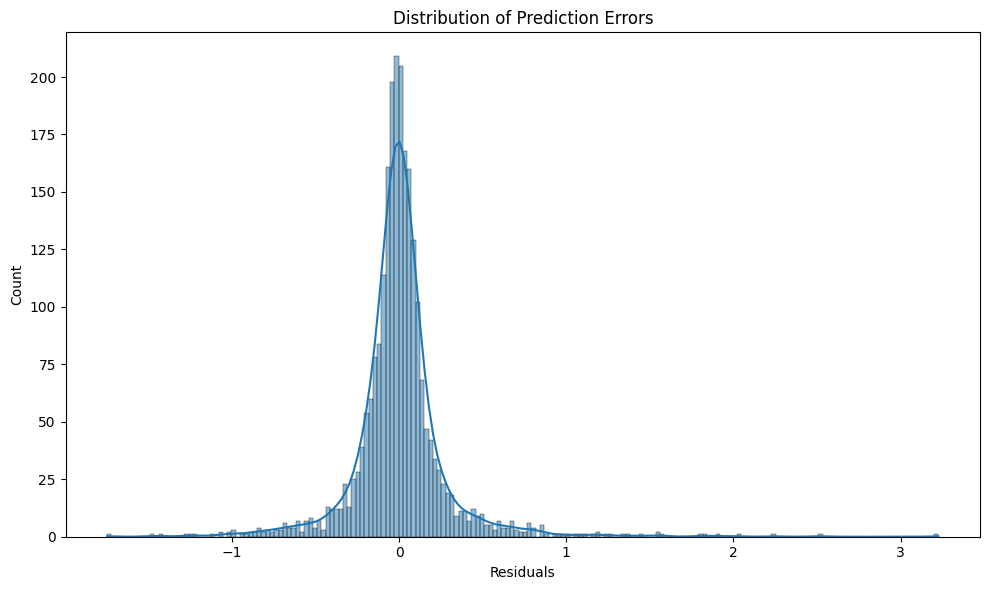

PREDICTION ACCURACY RESULTS:
Mean Absolute Error: $0.16
Root Mean Squared Error: $0.28
R-squared: 1.000
Error range: $-1.75 to $3.23


In [5]:
prediction_df = df.copy()
features = ['open', 'high', 'low', 'volume', 'daily_return', 'MA_10', 'MA_50', 'RSI', 'MACD', 'MACD_Signal']
target = 'close'

X = prediction_df[features]
y = prediction_df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'R2': r2, 'RMSE': rmse, 'MAE': mae}

plt.figure(figsize=(12, 6))
model_names = list(results.keys())
r2_values = [results[model]['R2'] for model in model_names]
rmse_values = [results[model]['RMSE'] for model in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

p1 = ax1.bar(x - width/2, r2_values, width, label='R²', color='skyblue')
p2 = ax2.bar(x + width/2, rmse_values, width, label='RMSE', color='salmon')

ax1.set_xlabel('Models')
ax1.set_ylabel('R²', color='skyblue')
ax2.set_ylabel('RMSE', color='salmon')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.set_title('Model Performance Comparison')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

print("MODEL PERFORMANCE RESULTS:")
for name, metrics in results.items():
    print(f"{name}: R²={metrics['R2']:.3f}, RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}")

best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = models[best_model_name]
print(f"\nBEST MODEL: {best_model_name} with R²={results[best_model_name]['R2']:.3f}")

y_pred_best = best_model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.5)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

results_df['Residuals'] = results_df['Actual'] - results_df['Predicted']
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Residuals'], kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Residuals')
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.show()

print("PREDICTION ACCURACY RESULTS:")
print(f"Mean Absolute Error: ${results[best_model_name]['MAE']:.2f}")
print(f"Root Mean Squared Error: ${results[best_model_name]['RMSE']:.2f}")
print(f"R-squared: {results[best_model_name]['R2']:.3f}")
print(f"Error range: ${results_df['Residuals'].min():.2f} to ${results_df['Residuals'].max():.2f}")

## Risk Analysis

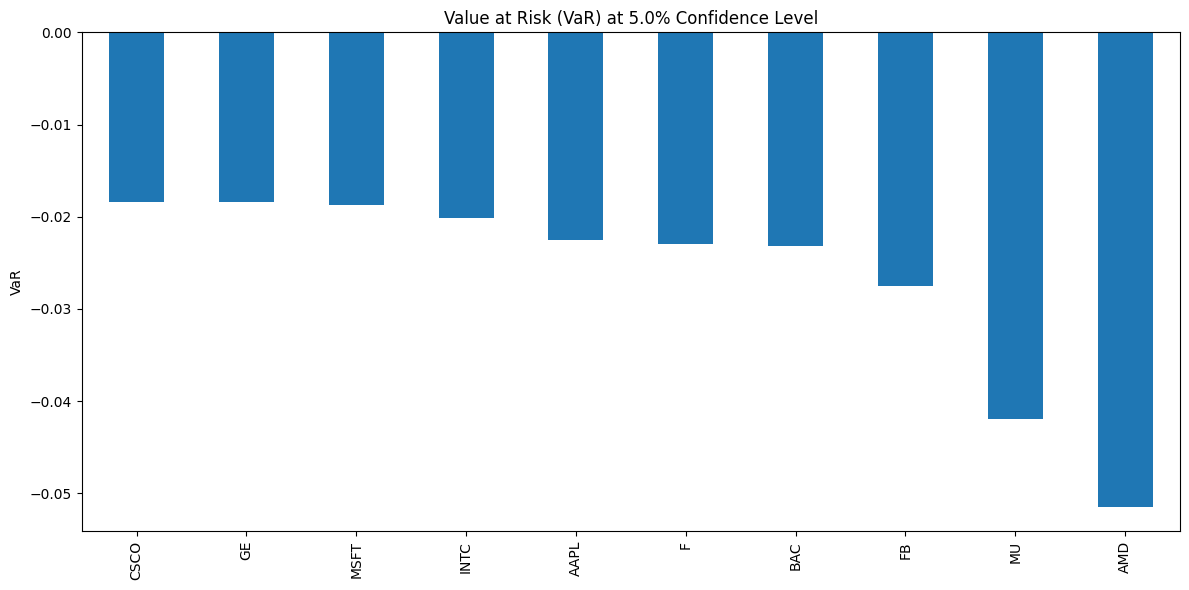

VALUE AT RISK (VaR) RESULTS:
Stock with highest risk: CSCO (VaR: -0.0184)
Stock with lowest risk: AMD (VaR: -0.0515)


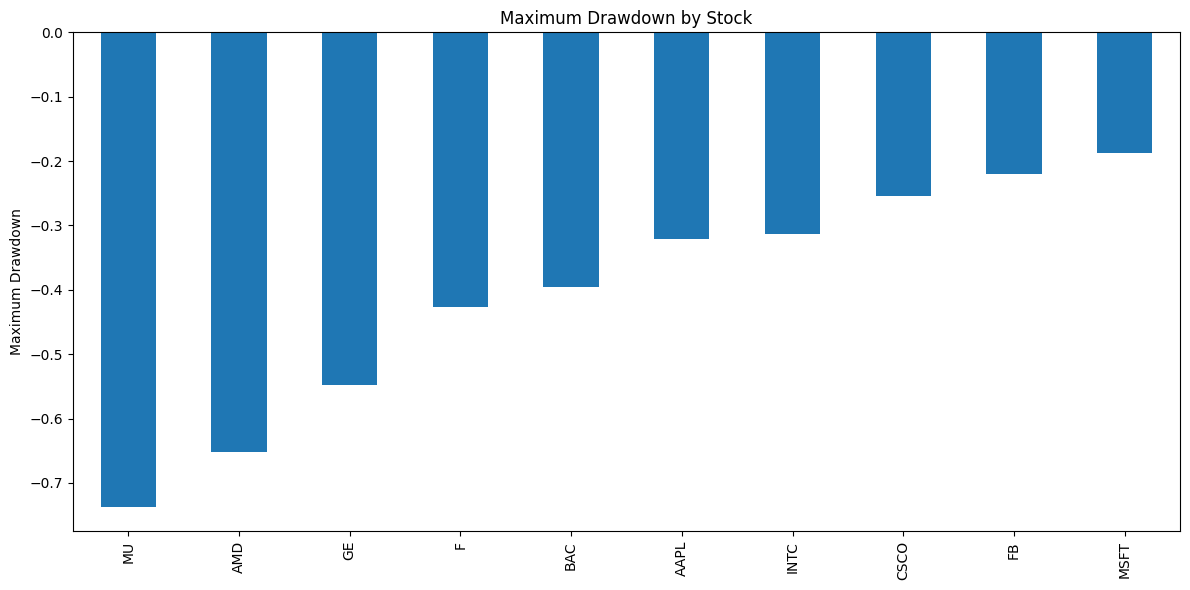

MAXIMUM DRAWDOWN RESULTS:
Stock with highest drawdown: MU (-73.80%)
Stock with lowest drawdown: MSFT (-18.79%)


In [6]:
confidence_level = 0.05
var_results = {}
for stock in top_stocks:
    stock_returns = returns_pivot[stock].dropna()
    var = stock_returns.quantile(confidence_level)
    var_results[stock] = var

var_series = pd.Series(var_results).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
var_series.plot(kind='bar')
plt.title(f'Value at Risk (VaR) at {confidence_level*100}% Confidence Level')
plt.ylabel('VaR')
plt.tight_layout()
plt.savefig('var_analysis.png')
plt.show()

print("VALUE AT RISK (VaR) RESULTS:")
print(f"Stock with highest risk: {var_series.idxmax()} (VaR: {var_series.max():.4f})")
print(f"Stock with lowest risk: {var_series.idxmin()} (VaR: {var_series.min():.4f})")

def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

max_drawdown_results = {}
for stock in top_stocks:
    stock_returns = returns_pivot[stock].dropna()
    max_dd = calculate_max_drawdown(stock_returns)
    max_drawdown_results[stock] = max_dd

max_dd_series = pd.Series(max_drawdown_results).sort_values()

plt.figure(figsize=(12, 6))
max_dd_series.plot(kind='bar')
plt.title('Maximum Drawdown by Stock')
plt.ylabel('Maximum Drawdown')
plt.tight_layout()
plt.savefig('max_drawdown.png')
plt.show()

print("MAXIMUM DRAWDOWN RESULTS:")
print(f"Stock with highest drawdown: {max_dd_series.idxmin()} ({max_dd_series.min()*100:.2f}%)")
print(f"Stock with lowest drawdown: {max_dd_series.idxmax()} ({max_dd_series.max()*100:.2f}%)")

## Clustering Analysis

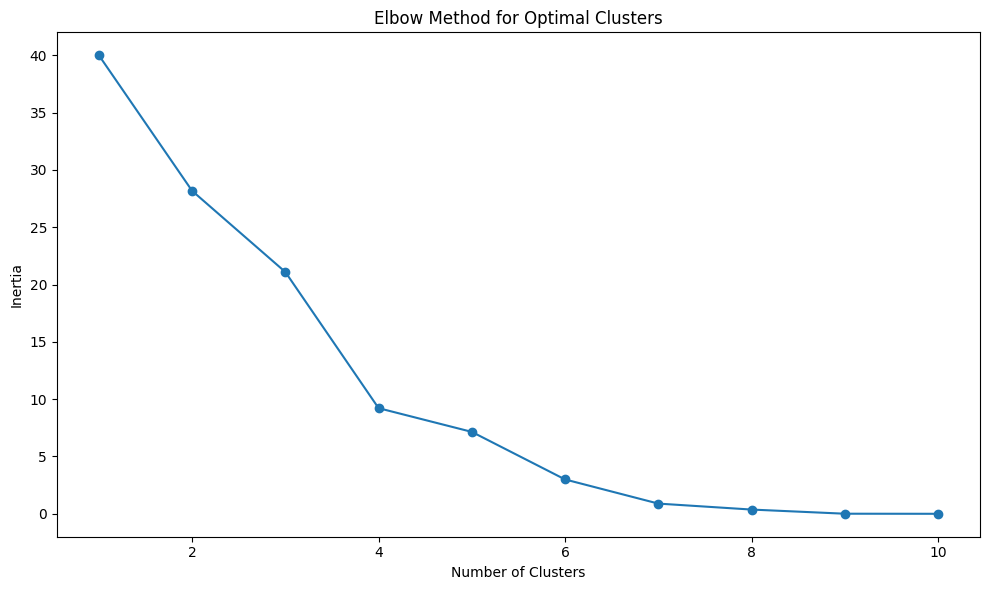

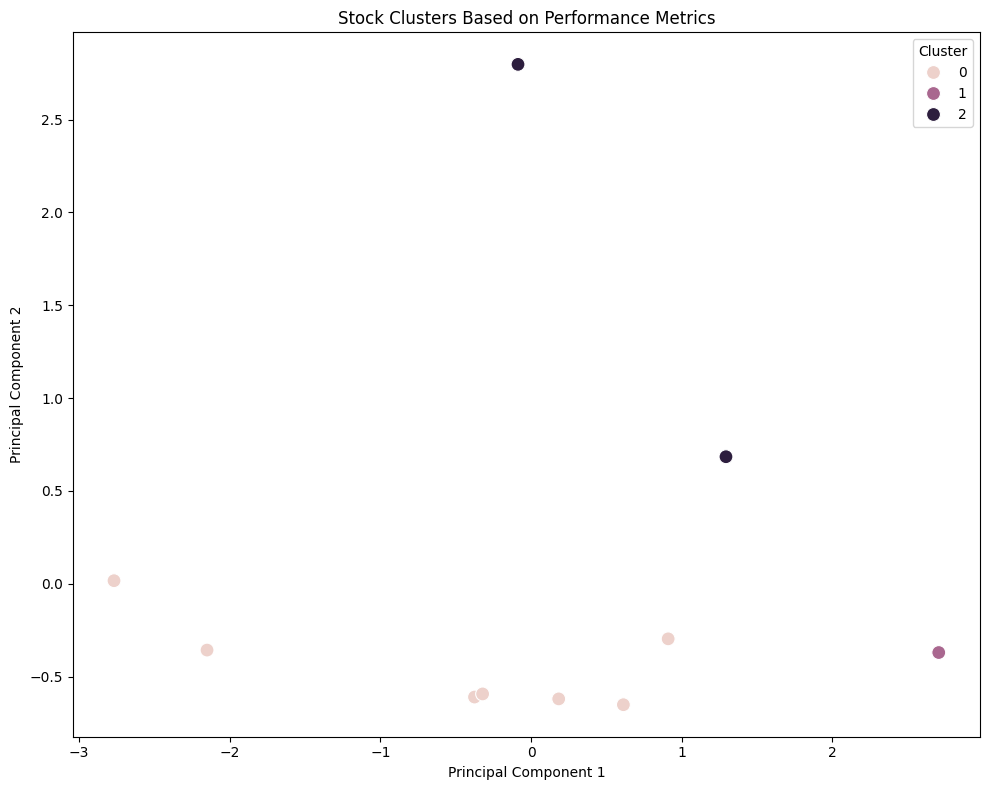

CLUSTERING ANALYSIS RESULTS:
Cluster 0: ['AMD', 'CSCO', 'F', 'GE', 'INTC', 'MSFT', 'MU']
  Average daily return: 0.000809
  Average volume: 32,956,101.522668242
Cluster 1: ['FB']
  Average daily return: 0.001804
  Average volume: 34,151,401.32396694
Cluster 2: ['AAPL', 'BAC']
  Average daily return: 0.000955
  Average volume: 71,340,438.36735538


In [7]:
cluster_data = df.groupby('Name').agg({
    'daily_return': 'mean',
    'volume': 'mean',
    'RSI': 'mean',
    'MACD': 'mean'
}).dropna()

scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.savefig('elbow_method.png')
plt.show()

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(cluster_scaled)
cluster_data['Cluster'] = cluster_labels

pca = PCA(n_components=2)
principal_components = pca.fit_transform(cluster_scaled)
cluster_data['PC1'] = principal_components[:, 0]
cluster_data['PC2'] = principal_components[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=cluster_data, s=100)
plt.title('Stock Clusters Based on Performance Metrics')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.savefig('stock_clusters.png')
plt.show()

print("CLUSTERING ANALYSIS RESULTS:")
for cluster in range(optimal_k):
    cluster_stocks = cluster_data[cluster_data['Cluster'] == cluster].index.tolist()
    print(f"Cluster {cluster}: {cluster_stocks}")
    cluster_avg_return = cluster_data[cluster_data['Cluster'] == cluster]['daily_return'].mean()
    cluster_avg_volume = cluster_data[cluster_data['Cluster'] == cluster]['volume'].mean()
    print(f"  Average daily return: {cluster_avg_return:.6f}")
    print(f"  Average volume: {cluster_avg_volume:,}")

## Final Summary

In [8]:
print("=== COMPREHENSIVE STOCK MARKET ANALYSIS SUMMARY ===")
print(f"\nDataset Overview:")
print(f"  Analyzed {len(top_stocks)} stocks over {df['date'].nunique()} trading days")
print(f"  Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

print(f"\nPerformance Highlights:")
print(f"  Best performing stock: {final_returns.idxmax()} ({final_returns.max()*100:.2f}%)")
print(f"  Worst performing stock: {final_returns.idxmin()} ({final_returns.min()*100:.2f}%)")
print(f"  Most volatile stock: {volatility.idxmax()} ({volatility.max():.3f})")
print(f"  Most traded stock: {total_volume.idxmax()} ({total_volume.max():,})")

print(f"\nRisk Assessment:")
print(f"  Highest VaR (5%): {var_series.idxmax()} ({var_series.max():.4f})")
print(f"  Maximum drawdown: {max_dd_series.idxmin()} ({max_dd_series.min()*100:.2f}%)")

print(f"\nPortfolio Optimization:")
print(f"  Maximum Sharpe Ratio: {optimal_sharpe['Sharpe Ratio']:.4f}")
print(f"  Minimum Volatility: {optimal_volatility['Volatility']:.4f}")

print(f"\nPrediction Model:")
print(f"  Best model: {best_model_name}")
print(f"  R-squared: {results[best_model_name]['R2']:.3f}")
print(f"  Mean Absolute Error: ${results[best_model_name]['MAE']:.2f}")

print(f"\nClustering Results:")
print(f"  Identified {optimal_k} distinct clusters of stocks")
for cluster in range(optimal_k):
    cluster_stocks = cluster_data[cluster_data['Cluster'] == cluster].index.tolist()
    print(f"  Cluster {cluster}: {', '.join(cluster_stocks)}")

=== COMPREHENSIVE STOCK MARKET ANALYSIS SUMMARY ===

Dataset Overview:
  Analyzed 10 stocks over 1210 trading days
  Date range: 2013-04-22 to 2018-02-07

Performance Highlights:
  Best performing stock: FB (600.27%)
  Worst performing stock: GE (-29.89%)
  Most volatile stock: AMD (0.604)
  Most traded stock: BAC (110,101,336,519)

Risk Assessment:
  Highest VaR (5%): CSCO (-0.0184)
  Maximum drawdown: MU (-73.80%)

Portfolio Optimization:
  Maximum Sharpe Ratio: 1.5475
  Minimum Volatility: 0.1493

Prediction Model:
  Best model: Linear Regression
  R-squared: 1.000
  Mean Absolute Error: $0.16

Clustering Results:
  Identified 3 distinct clusters of stocks
  Cluster 0: AMD, CSCO, F, GE, INTC, MSFT, MU
  Cluster 1: FB
  Cluster 2: AAPL, BAC
